<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>neural network architecture</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li></ul></div>

# setup

In [99]:
import datetime
import gc
import hashlib
import json
import os
import pickle
import pprint
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from IPython.display import display
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
    mean_squared_error,
    r2_score,
    roc_curve,
)
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize

from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation
from PIL import Image
from scipy.interpolate import griddata

In [2]:
warnings.filterwarnings("ignore")
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")

golden_ratio = (np.sqrt(5) - 1) / 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [3]:
plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [4]:
experiment_name = "lagrangian"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [5]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

# equations of motion

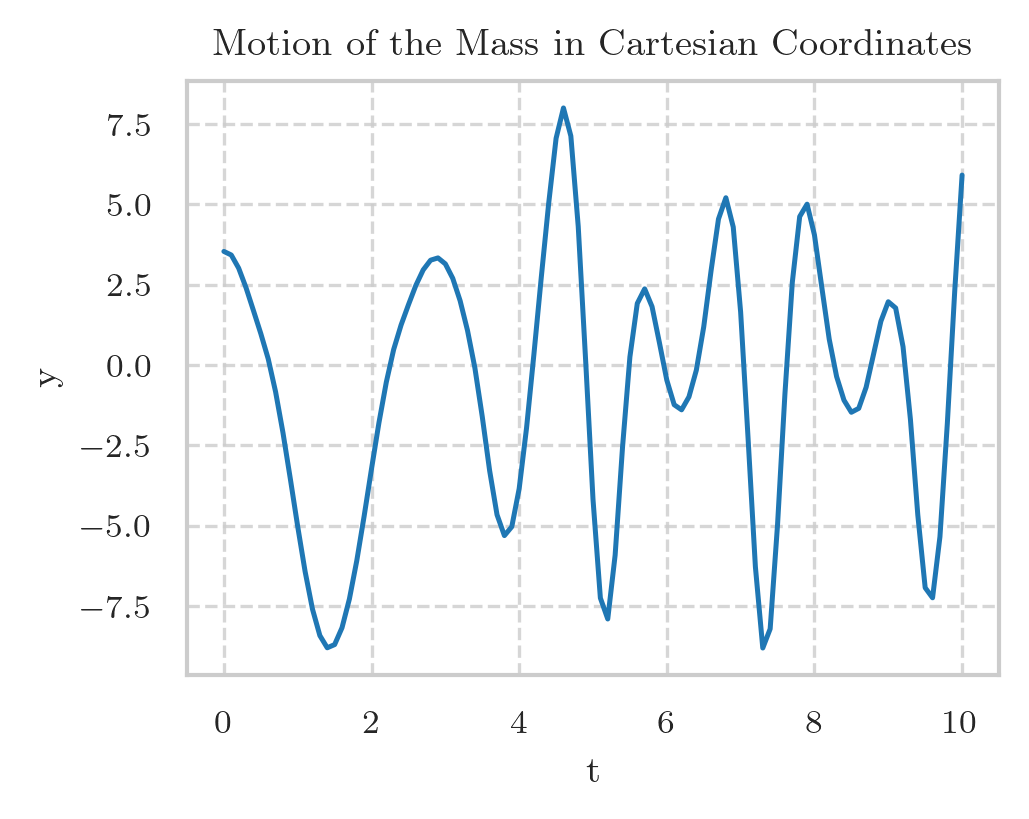

In [77]:
m = 1.23
R = 5.0    
a = 4.0
omega = 3.21
g = 9.81

theta0 = np.pi / 4 
theta_dot0 = -3.5   

t_start = 0.0
t_end = 10.0
dt = 0.1

t_values = list()
x_values = list()
y_values = list()
z_values = list()

theta = theta0
theta_dot = theta_dot0
t = t_start

while t <= t_end:
    x = R * np.cos(theta)
    y = R * np.sin(theta) + a * np.sin(omega * t)
    
    t_values.append(t)
    x_values.append(x)
    y_values.append(y)
    z_values.append(a * np.sin(omega * t))
    
    theta_double_dot = (m * R * a * omega**2 * np.sin(omega * t) * np.cos(theta) - m * R * a * omega * theta_dot * np.cos(omega * t)) / (m * (R**2 + a**2 * omega**2 * np.cos(omega * t)**2))

    theta_dot += theta_double_dot * dt
    theta += theta_dot * dt    
    t += dt

plt.plot(t_values, y_values)
plt.title("Motion of the Mass in Cartesian Coordinates")
plt.xlabel("t")
plt.ylabel("y")

plt.tight_layout()
plt.savefig(f"{folder_path}/motion.png", bbox_inches="tight", dpi=300)

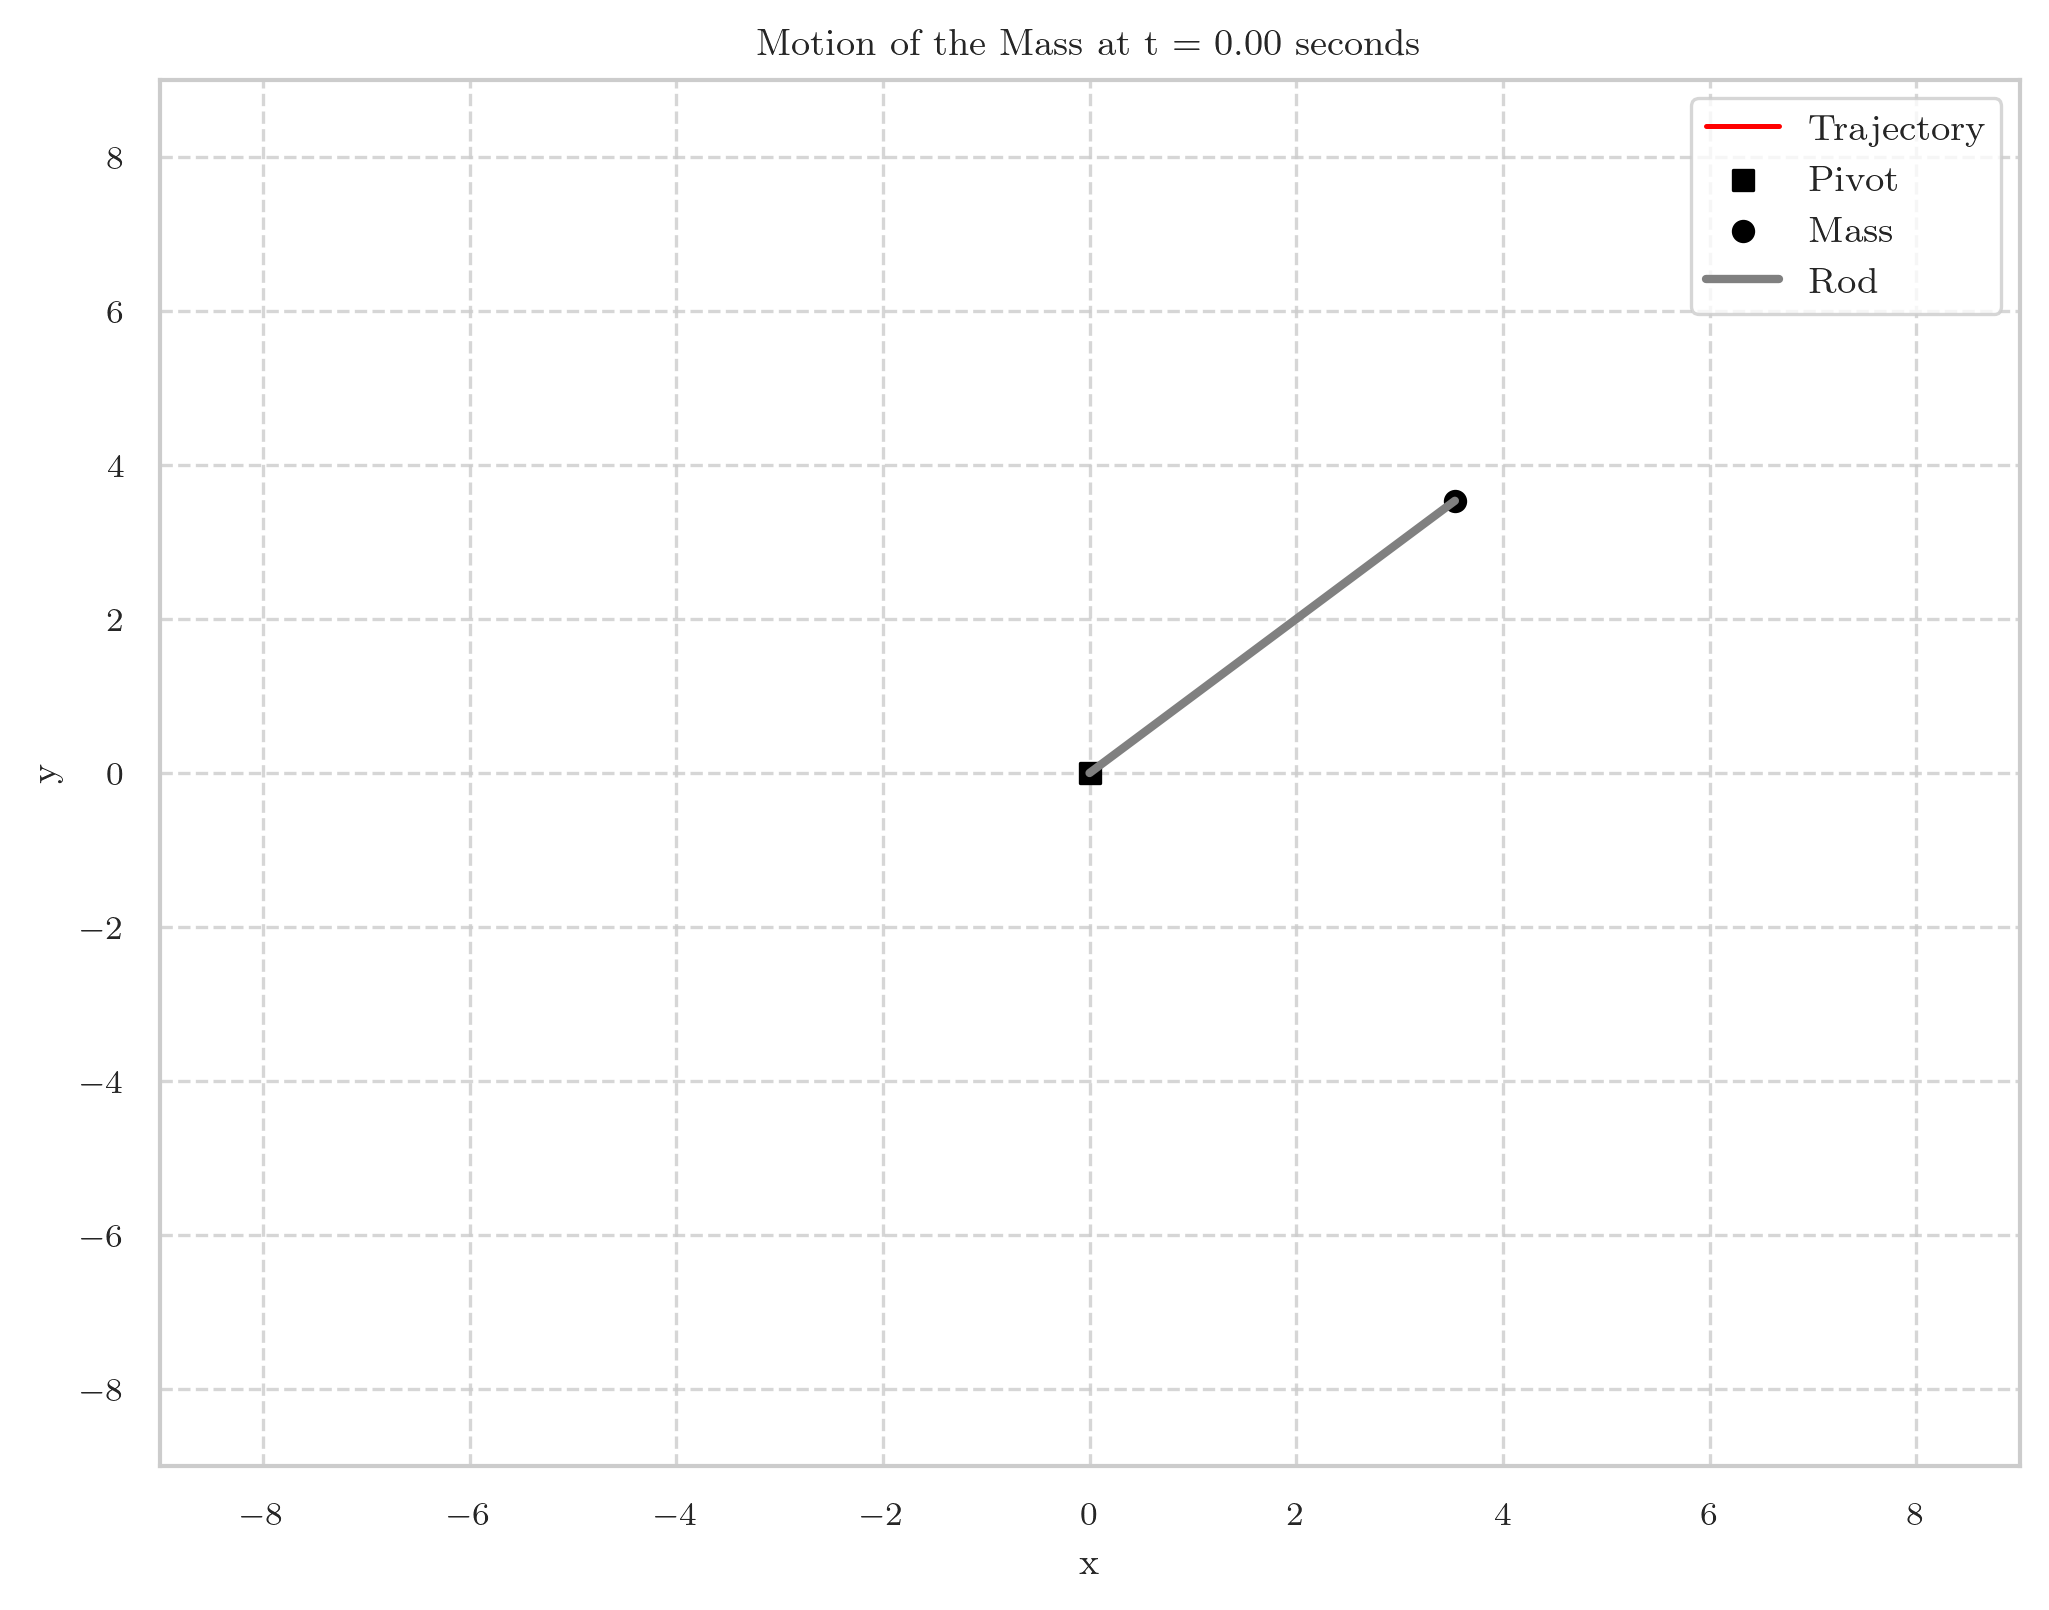

In [78]:
def update(frame):
    plt.cla()
    plt.xlim(-(R+a), (R+a))
    plt.ylim(-(R+a), (R+a))

    t = t_values[frame]
    x = x_values[frame]
    y = y_values[frame]
    z = z_values[frame]
    
    plt.plot(x_values[:frame], y_values[:frame], color='r', label='Trajectory')
    plt.scatter(0, z, marker='s', color='k', label='Pivot')
    plt.scatter(x, y, marker='o', color='k', label='Mass')
    plt.plot([0, x], [z, y], color='gray', linewidth=2, label='Rod')
    
    plt.title(f"Motion of the Mass at t = {t:.2f} seconds")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

fig, ax = plt.subplots(figsize=(8, 6))

ani = FuncAnimation(fig, update, frames=len(t_values), interval=50)

ani.save(f"{folder_path}/mass_motion_animation.gif", writer='pillow', fps=10)
plt.savefig(f"{folder_path}/mass_motion_animation.png", dpi=300, bbox_inches='tight') ;

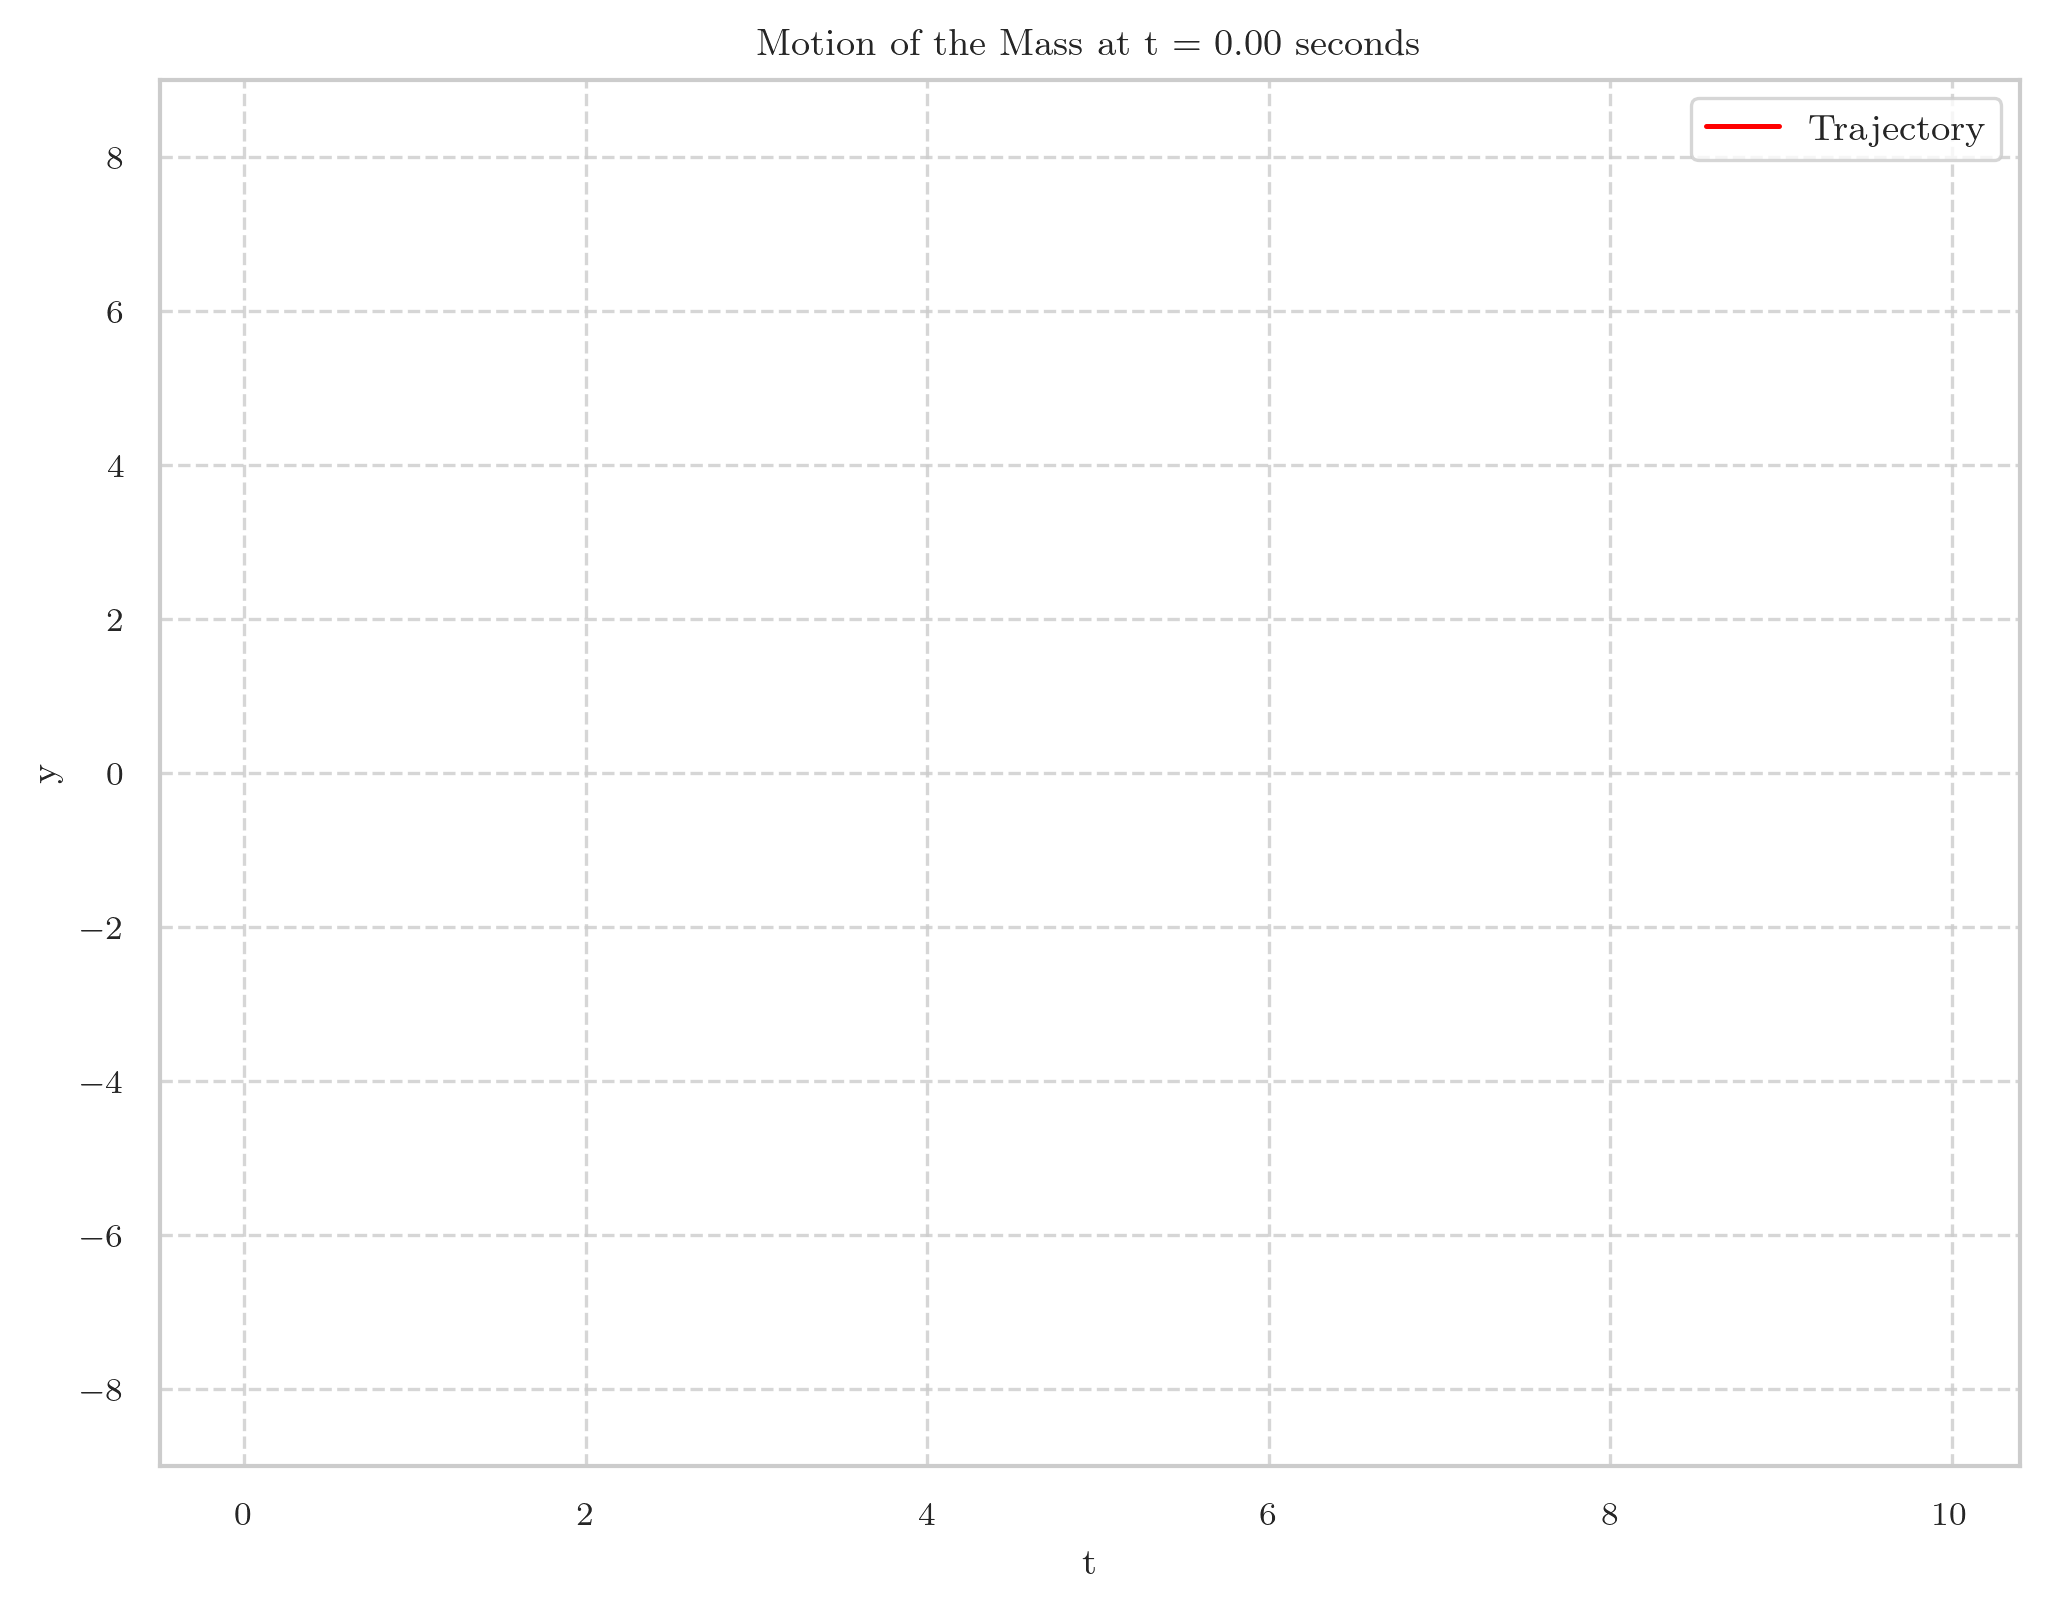

In [79]:
def update(frame):
    plt.cla()
    plt.ylim(-(R+a), (R+a))

    t = t_values[frame]
    x = x_values[frame]
    y = y_values[frame]
    
    plt.plot(t_values[:frame], y_values[:frame], color='r', label='Trajectory')
    
    plt.title(f"Motion of the Mass at t = {t:.2f} seconds")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.legend()

fig, ax = plt.subplots(figsize=(8, 6))

ani = FuncAnimation(fig, update, frames=len(t_values), interval=50)

ani.save(f"{folder_path}/motion_animation.gif", writer='pillow', fps=10)
plt.savefig(f"{folder_path}/motion_animation.png", dpi=300, bbox_inches='tight') ;

In [80]:
gc.collect()

28423

# pinn

## data

In [82]:
data = pd.DataFrame(
    {
        "t": t_values,
        "x": x_values,
        "y": y_values,
        "z": z_values
    }
)
data.to_parquet(f"{folder_path}/data.parquet", index=False)

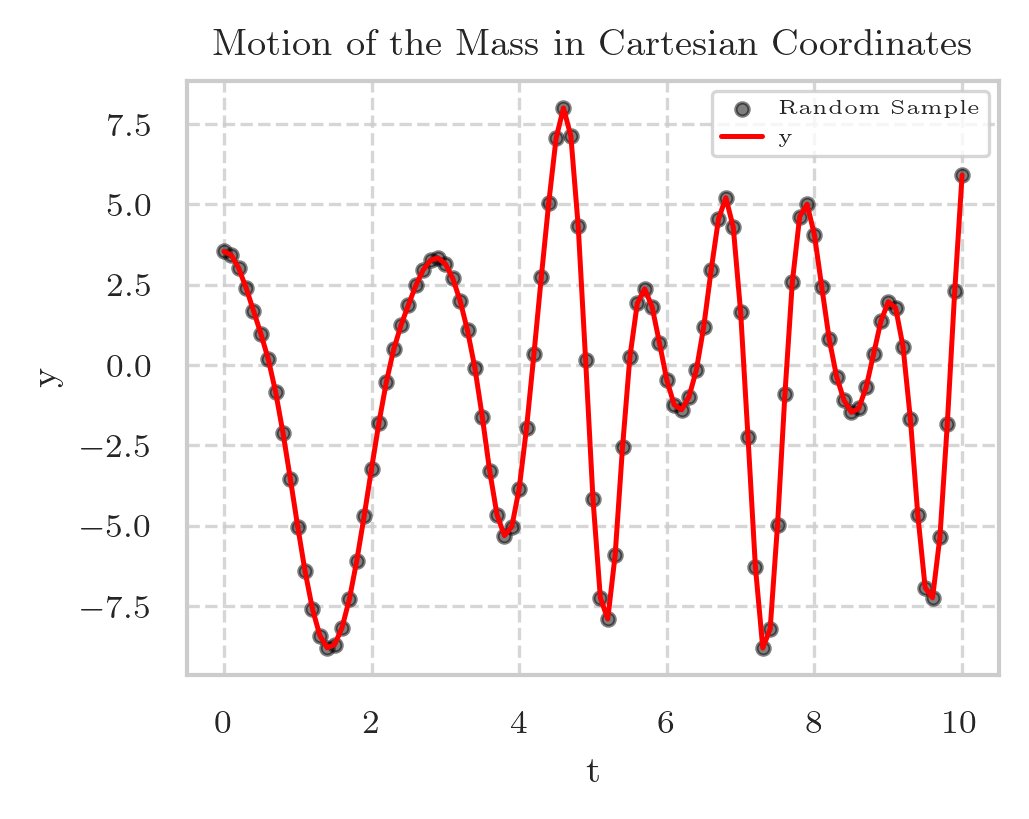

In [183]:
fig, ax = plt.subplots()

_sample = data.copy()
_sample.plot.scatter(x="t", y="y", marker="o", color="k", s=10, alpha=0.5, ax=ax, label="Random Sample")
data.plot.line(x="t", y="y", color="r", ax=ax)

ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("Motion of the Mass in Cartesian Coordinates")
ax.legend(fontsize=5)

plt.tight_layout()
plt.savefig(f"{folder_path}/motion_sample.png", dpi=300, bbox_inches="tight")

In [184]:
_sample["theta"] = np.arctan((_sample["y"] - a * np.sin(omega * _sample["t"])) / _sample["x"])

_sample

,t,x,y,z,theta
0,0.0,3.535534,3.535534,0.000000,0.785398
1,0.1,4.508236,3.424424,1.262063,0.447233
2,0.2,4.961408,3.015217,2.395194,0.124325
3,0.3,4.922304,2.405609,3.283634,-0.176520
4,0.4,4.519026,1.696899,3.836620,-0.442217
...,...,...,...,...,...
96,9.6,0.354128,-7.245771,-2.258327,-1.499911
97,9.7,-2.643851,-5.345120,-1.101295,1.013645
98,9.8,-4.587288,-1.820925,0.168244,0.409154
99,9.9,-4.923369,2.292627,1.420596,-0.175303


In [185]:
torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(_sample["t"].values, dtype=torch.float32).reshape(-1, 1).to(device)
y_train = torch.tensor(_sample["theta"].values, dtype=torch.float32).reshape(-1, 1).to(device)

x_axis = torch.tensor(_sample["x"].values, dtype=torch.float32).reshape(-1, 1).to(device)
y_axis = torch.tensor(_sample["y"].values, dtype=torch.float32).reshape(-1, 1).to(device)

## neural network architecture

In [186]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

## training

$\begin{cases} x = R cos \theta \\ z = a sin (\omega t) = a sin (\omega t) + R sin \theta \end{cases}$

e

$\mathcal{L} = \frac{1}{2} m \left( R^2 \dot{\theta}^2 + a^2 \omega^2 cos^2 (\omega t) + 2 R a \omega cos (\omega t)cos \theta \dot{\theta} \right) - m g ( a sin (\omega t) + R sin \theta )$

e

$\frac{\partial \mathcal{L}}{\partial q} - \frac{d}{dt} \left( \frac{\partial \mathcal{L}}{\partial \dot{q}} \right) = 0$

In [193]:
hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 32,
    'num_epochs': 30000,
}

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]
architecture = [1, 64, 64, 64, 64, 1]

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

_R = torch.tensor(R, dtype=torch.float, device=device, requires_grad=False)
_a = torch.tensor(a, dtype=torch.float, device=device, requires_grad=False)
_omega = torch.tensor(0.0, dtype=torch.float, device=device, requires_grad=True)
_m = torch.tensor(m, dtype=torch.float, device=device, requires_grad=False)
_g = torch.tensor(g, dtype=torch.float, device=device, requires_grad=False)

_collocation = torch.linspace(0, 10, 100, dtype=torch.float, device=device, requires_grad=True).reshape(-1, 1)

model = MultiLayerPerceptronRegressor(architecture, nn.ELU)
model.to(device)

optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_omega]}
    ],
    lr=learning_rate
)
criterion = nn.MSELoss()
loss = torch.tensor(1e6, dtype=torch.float, requires_grad=False).to(device)

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], param_omega=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    # if loss.item() > 1e-10 or epoch < 10000:
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        theta_hat = model(_collocation)
        dot_theta_hat = torch.autograd.grad(theta_hat, _collocation, grad_outputs=torch.ones_like(_collocation), create_graph=True)[0]

        _L = 0.5*_m * (_R**2 * dot_theta_hat**2 + _a**2 * _omega**2 * torch.cos(_omega * _collocation)**2 + 2*_R*_a*_omega*torch.cos(_omega * _collocation)*torch.cos(theta_hat)*dot_theta_hat) - _m*_g*(_a*torch.sin(_omega * _collocation) + _R*torch.sin(theta_hat))
        
        dLdtheta = torch.autograd.grad(_L, theta_hat, grad_outputs=torch.ones_like(theta_hat), create_graph=True)[0]
        dLddottheta = torch.autograd.grad(_L, dot_theta_hat, grad_outputs=torch.ones_like(dot_theta_hat), create_graph=True)[0]
        dt_dLddottheta = torch.autograd.grad(dLddottheta, _collocation, grad_outputs=torch.ones_like(_collocation), create_graph=True)[0]

        physics_loss = torch.mean((dLdtheta - dt_dLddottheta)**2)

        loss = data_loss + (1e-3)*(physics_loss)
        
        # backward
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            str_epoch = str(epoch+1).zfill(5)
            str_num_epochs = str(num_epochs).zfill(5)
            str_loss = str(round(loss.item(), 4))
            str_physics_loss = str(round(physics_loss.item(), 4))
            print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
            print(f"omega: {_omega.item()}")
            # print("F0: ", _F0.item())
            # print("alpha: ", _alpha.item())
            # print("nu: ", _nu.item())
            # print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}")

        if (epoch+1) % 5 == 0:
            plot_loss_train["epoch"].append(epoch+1)
            plot_loss_train["dataloss"].append(data_loss.item())
            # plot_loss_train["physicsloss"].append(physics_loss.item())
            # plot_loss_train["param_alpha"].append(_alpha.item())
            # plot_loss_train["param_nu"].append(_nu.item())

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


  0%|          | 12/30000 [00:00<04:19, 115.56it/s]

  3%|▎         | 1022/30000 [00:06<02:37, 183.92it/s]

epoch [01000/30000] loss: 2.4136 physics loss: 412.8143
omega: 0.3424014151096344


  7%|▋         | 2020/30000 [00:11<02:39, 175.27it/s]

epoch [02000/30000] loss: 2.5651 physics loss: 531.4872
omega: 0.6719078421592712


 10%|█         | 3022/30000 [00:17<02:36, 172.05it/s]

epoch [03000/30000] loss: 2.5329 physics loss: 1155.8475
omega: 0.9559007883071899


 13%|█▎        | 4023/30000 [00:23<02:19, 186.35it/s]

epoch [04000/30000] loss: 2.113 physics loss: 493.6605
omega: 0.9890764355659485


 17%|█▋        | 5020/30000 [00:28<02:30, 165.82it/s]

epoch [05000/30000] loss: 2.2284 physics loss: 752.226
omega: 1.0066053867340088


 20%|██        | 6024/30000 [00:34<02:12, 181.03it/s]

epoch [06000/30000] loss: 2.3102 physics loss: 481.6475
omega: 1.003231406211853


 23%|██▎       | 7023/30000 [00:40<02:13, 171.71it/s]

epoch [07000/30000] loss: 2.1151 physics loss: 419.6824
omega: 0.9707914590835571


 27%|██▋       | 8022/30000 [00:45<02:05, 174.46it/s]

epoch [08000/30000] loss: 2.2264 physics loss: 778.3776
omega: 0.9626505970954895


 30%|███       | 9024/30000 [00:51<02:07, 164.42it/s]

epoch [09000/30000] loss: 2.265 physics loss: 885.5341
omega: 0.9622227549552917


 33%|███▎      | 10019/30000 [00:57<01:58, 169.00it/s]

epoch [10000/30000] loss: 2.1226 physics loss: 603.674
omega: 0.9574074745178223


 37%|███▋      | 11032/30000 [01:03<01:51, 170.13it/s]

epoch [11000/30000] loss: 2.0707 physics loss: 349.8087
omega: 0.964522659778595


 40%|████      | 12023/30000 [01:09<01:44, 172.20it/s]

epoch [12000/30000] loss: 2.085 physics loss: 444.4786
omega: 0.961195170879364


 43%|████▎     | 13036/30000 [01:14<01:30, 187.67it/s]

epoch [13000/30000] loss: 2.112 physics loss: 324.79
omega: 0.9580114483833313


 47%|████▋     | 14034/30000 [01:20<01:22, 193.95it/s]

epoch [14000/30000] loss: 2.1913 physics loss: 698.3775
omega: 0.9529173970222473


 50%|█████     | 15030/30000 [01:26<01:22, 181.14it/s]

epoch [15000/30000] loss: 2.1013 physics loss: 349.2468
omega: 0.9683125615119934


 53%|█████▎    | 16031/30000 [01:31<01:21, 170.49it/s]

epoch [16000/30000] loss: 2.1084 physics loss: 542.2739
omega: 0.9533217549324036


 57%|█████▋    | 17034/30000 [01:37<01:07, 190.77it/s]

epoch [17000/30000] loss: 2.1041 physics loss: 296.0612
omega: 0.9552121758460999


 60%|██████    | 18020/30000 [01:42<01:15, 157.67it/s]

epoch [18000/30000] loss: 2.0792 physics loss: 495.2355
omega: 0.9731591939926147


 63%|██████▎   | 19028/30000 [01:48<00:59, 185.68it/s]

epoch [19000/30000] loss: 2.0994 physics loss: 500.1083
omega: 0.9918401837348938


 67%|██████▋   | 20032/30000 [01:54<00:59, 168.88it/s]

epoch [20000/30000] loss: 2.0508 physics loss: 321.9259
omega: 0.9673992395401001


 70%|███████   | 21029/30000 [02:00<00:55, 162.74it/s]

epoch [21000/30000] loss: 2.4506 physics loss: 487.6755
omega: 0.9316097497940063


 73%|███████▎  | 22028/30000 [02:06<00:45, 174.69it/s]

epoch [22000/30000] loss: 2.3085 physics loss: 517.1618
omega: 0.9720759391784668


 77%|███████▋  | 23032/30000 [02:12<00:41, 168.65it/s]

epoch [23000/30000] loss: 2.2638 physics loss: 584.5123
omega: 0.9646057486534119


 80%|████████  | 24025/30000 [02:18<00:35, 170.42it/s]

epoch [24000/30000] loss: 2.5619 physics loss: 1134.7517
omega: 0.9606085419654846


 83%|████████▎ | 25025/30000 [02:24<00:30, 163.84it/s]

epoch [25000/30000] loss: 2.3061 physics loss: 855.2886
omega: 0.9681487083435059


 87%|████████▋ | 26030/30000 [02:29<00:22, 175.33it/s]

epoch [26000/30000] loss: 2.2406 physics loss: 681.8389
omega: 0.969730019569397


 90%|█████████ | 27014/30000 [02:35<00:19, 154.76it/s]

epoch [27000/30000] loss: 2.3626 physics loss: 377.364
omega: 0.9272969961166382


 93%|█████████▎| 28026/30000 [02:41<00:11, 172.78it/s]

epoch [28000/30000] loss: 2.2812 physics loss: 597.5709
omega: 0.9801635146141052


 97%|█████████▋| 29020/30000 [02:46<00:05, 178.33it/s]

epoch [29000/30000] loss: 2.3578 physics loss: 425.6034
omega: 0.9964491724967957


100%|██████████| 30000/30000 [02:52<00:00, 173.59it/s]

epoch [30000/30000] loss: 2.37 physics loss: 566.8045
omega: 0.9987213611602783


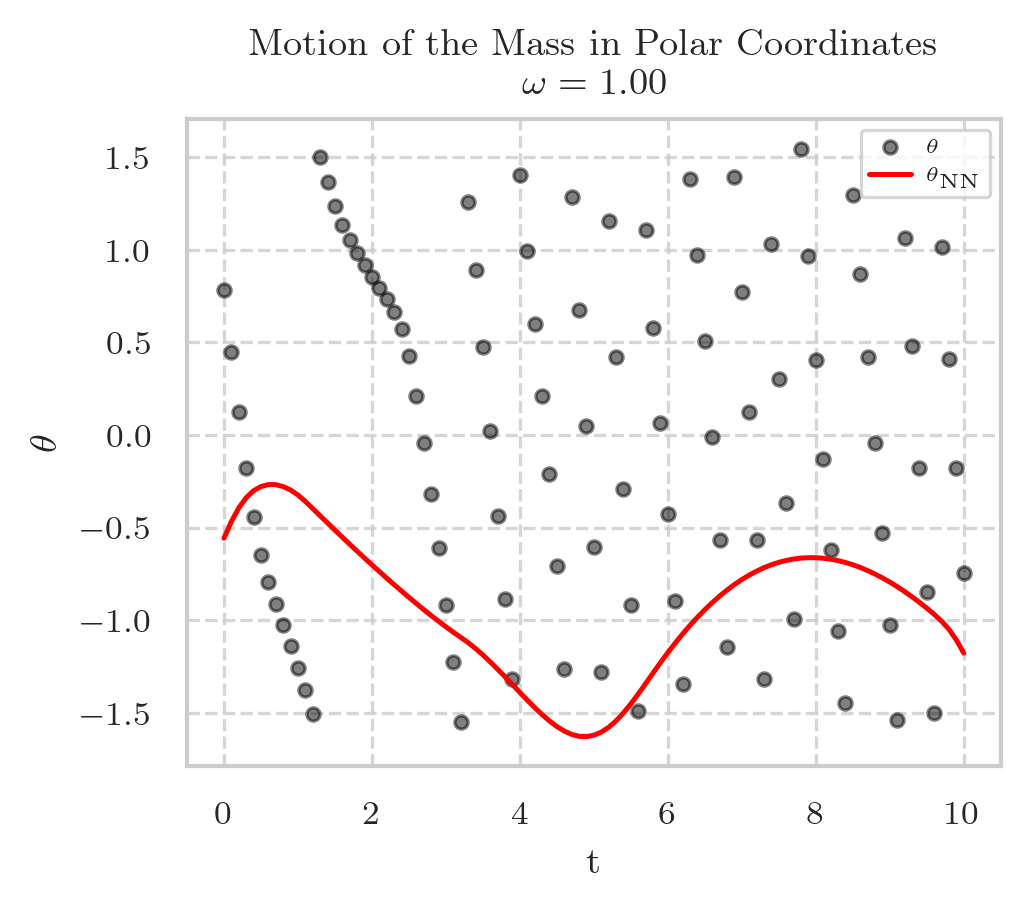

In [194]:
_result = _sample.copy()

fig, ax = plt.subplots()

model.eval()

with torch.no_grad():
    _result["theta_hat"] = model(x_train).cpu().numpy()
    _result["y_hat"] = _R.cpu().numpy() * np.sin(_result["theta_hat"]) + _a.cpu().numpy() * np.sin(_omega.cpu().numpy() * _result["t"])

_result = _result.sort_values(by="t")

ax.scatter(_result["t"], _result["theta"], marker="o", color="k", s=10, alpha=0.5, label="$\\theta$")
ax.plot(_result["t"], _result["theta_hat"], color="r", label="$\\theta_{\\mathrm{NN}}$")

ax.set_xlabel("t")
ax.set_ylabel("$\\theta$")
ax.set_title("Motion of the Mass in Polar Coordinates \n $\\omega = " + f"{_omega.item():.2f}$")
ax.legend(fontsize=5)


In [189]:
# save model in h5
torch.save(model.state_dict(), f"{folder_path}/model.h5")

.